# ARIMA Model and Algorithmic Trading Solution

## Data Load

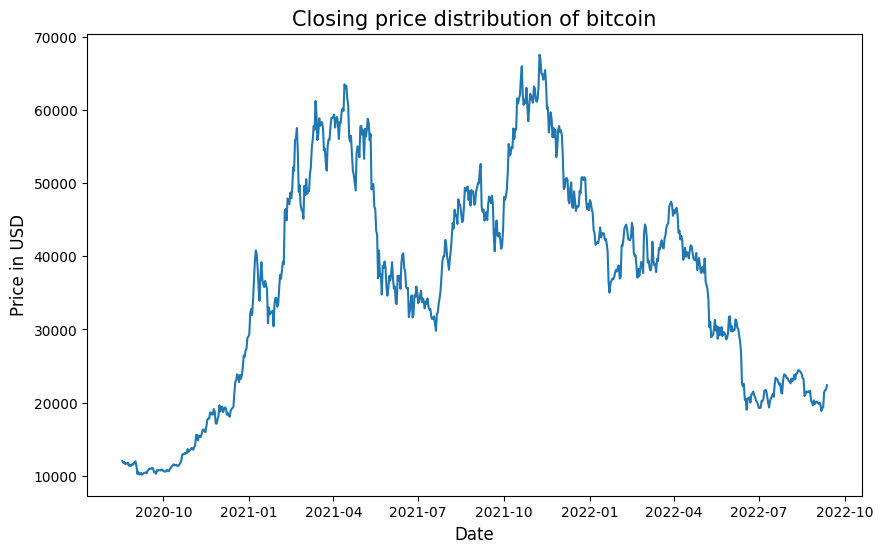

In [706]:
# price data load

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from yahoofinancials import YahooFinancials
from scipy.interpolate import interp1d
import random
import plotly.express as px
import warnings 
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore')

pd.set_option('display.max_rows', 500)

start_date = '2020-08-18'
end_date = '2022-09-12'
freq = 'daily'

#cryptocurrencies
ticker_BTC = 'BTC-USD'
#S&P500
ticker_snp = '^GSPC'
#VIX
ticker_vix = '^VIX'
#MSCIworld
ticker_msci = 'URTH'
#Gold
ticker_gld = 'GC=F'
#Crude Oil
ticker_oil = 'CL=F'
#EUR/USD
ticker_eur = 'EURUSD=X'
#CNY/USD
ticker_cny = 'CNYUSD=X'
#JPY/USD
ticker_jpy = 'JPYUSD=X'


#extract BTC close price
yahoo_financials = YahooFinancials(ticker_BTC)
historical_stock_prices = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
df_btc = pd.DataFrame(historical_stock_prices[ticker_BTC]['prices'])
df_btc = df_btc.rename(columns = {'close':'close_btc'})
df_btc = df_btc.drop(columns='date').rename(columns = {'formatted_date':'date'})
df_btc = df_btc[['date', 'close_btc']] 
df_btc

#extract exogeneous price variables
tickers_list = [ticker_snp, ticker_vix, ticker_msci, ticker_gld, ticker_oil, ticker_eur, ticker_cny, ticker_jpy]
price_list = ['snp', 'vix','msci', 'gold', 'oil', 'eur_usd', 'cny_usd', 'jpy_usd']
price_list_df = {}

for price, ticker in zip(price_list,tickers_list):
    yahoo_financials = YahooFinancials(ticker)
    historical_stock_prices = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(historical_stock_prices[ticker]['prices'])
    df = df.rename(columns={'open':f"open_{price}"})
    df = df.drop(columns = 'date').rename(columns = {'formatted_date':'date'})
    price_list_df[price] = df[['date', f"open_{price}"]]



    # print(f"Historical price data of {price}:\n")
    # print(price_list_df[price],'\n')

# Extract twitter sentiments
tweets_df = pd.read_csv('tweet_data_series.csv').rename(columns={'Unnamed: 0' : 'date'})
tweets_df['Polarity_shift'] = tweets_df['Polarity'].shift()

#merge all data features
final_df = pd.merge(df_btc, price_list_df['gold'], how='left', on='date')
final_df = final_df.merge(price_list_df['vix'], how='left', on='date')
final_df = final_df.merge(price_list_df['snp'], how='left', on='date')
final_df = final_df.merge(price_list_df['msci'], how='left', on='date')
final_df = final_df.merge(price_list_df['oil'], how='left', on='date')
final_df = final_df.merge(price_list_df['eur_usd'], how='left', on='date')
final_df = final_df.merge(price_list_df['cny_usd'], how='left', on='date')
final_df = final_df.merge(price_list_df['jpy_usd'], how='left', on='date')
final_df = final_df.merge(tweets_df, how='left', on='date')

final_df['date'] = pd.to_datetime(final_df['date'])
final_df = final_df.ffill()
final_df = final_df.bfill()

# # log-transform features
final_df['close_btc_log'] = np.log(final_df[f"close_btc"])
for price in price_list:
    final_df[f"open_{price}_log"] = np.log(final_df[f"open_{price}"])


final_df2 = final_df.set_index('date')
final_df2.sort_index(inplace=True)

#Plot bitcoin close price
plt.plot(final_df2['close_btc'])
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Closing price distribution of bitcoin", fontsize=15)
plt.show()


## Test stationarity

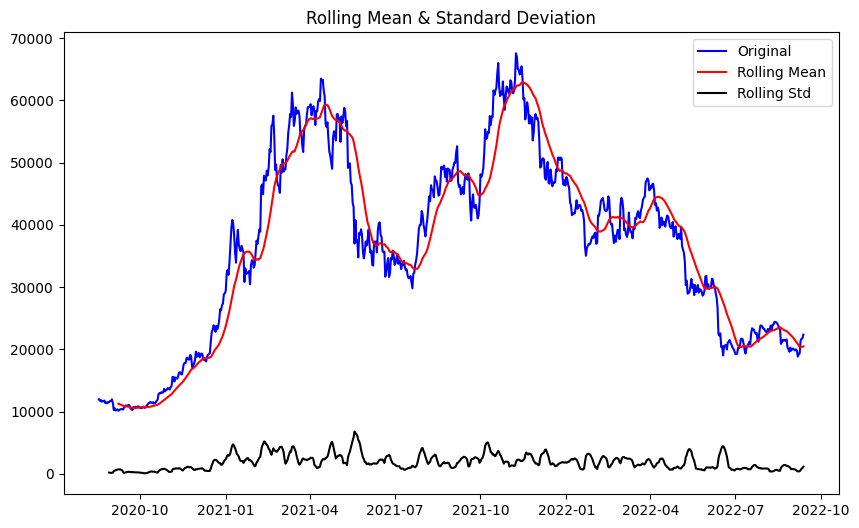

Results of Dickey Fuller Test:
Test Statistic                  -1.697832
p-value                          0.432230
#Lags Used                       0.000000
Number of Observations Used    755.000000
Critical Value (1%)             -3.439041
Critical Value (5%)             -2.865376
Critical Value (10%)            -2.568813
dtype: float64
The graph is non stationery


In [670]:
def test_stationarity(timeseries):


    #Determing rolling statistics
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=22).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    for key,value in dftest[4].items():
        if dftest[0]>value:
            print("The graph is non stationery")
            break
        else:
            print("The graph is stationery")
            break;
        
test_stat = final_df2.copy(deep=True)      
test_stationarity(test_stat['close_btc'])

### Test Log stationarity

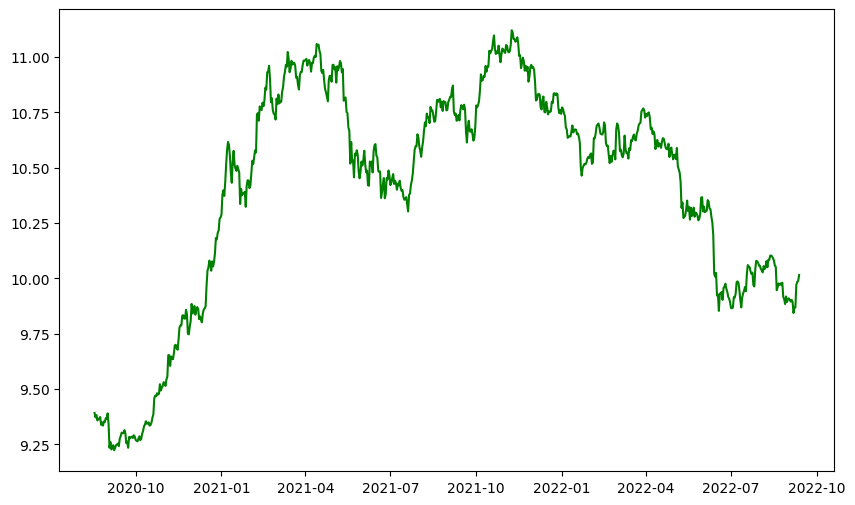

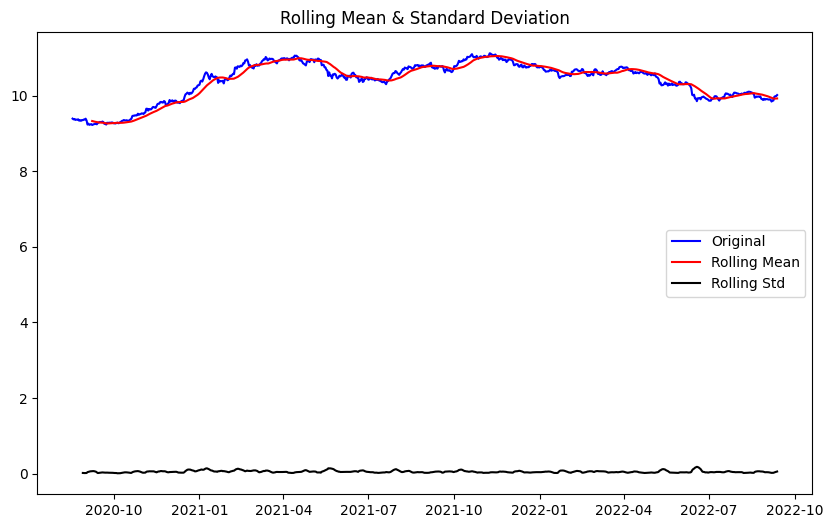

Results of Dickey Fuller Test:
Test Statistic                  -1.867457
p-value                          0.347522
#Lags Used                       0.000000
Number of Observations Used    755.000000
Critical Value (1%)             -3.439041
Critical Value (5%)             -2.865376
Critical Value (10%)            -2.568813
dtype: float64
The graph is non stationery


In [671]:
test_stat_log = np.log(test_stat['close_btc'])
plt.plot(test_stat_log,color="green")
plt.show()

test_stationarity(test_stat_log)


### Test Log Differences stationarity

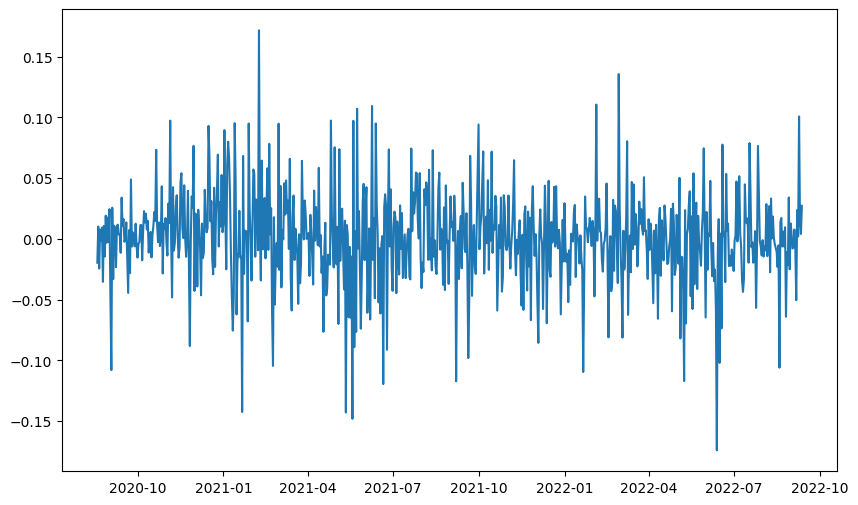

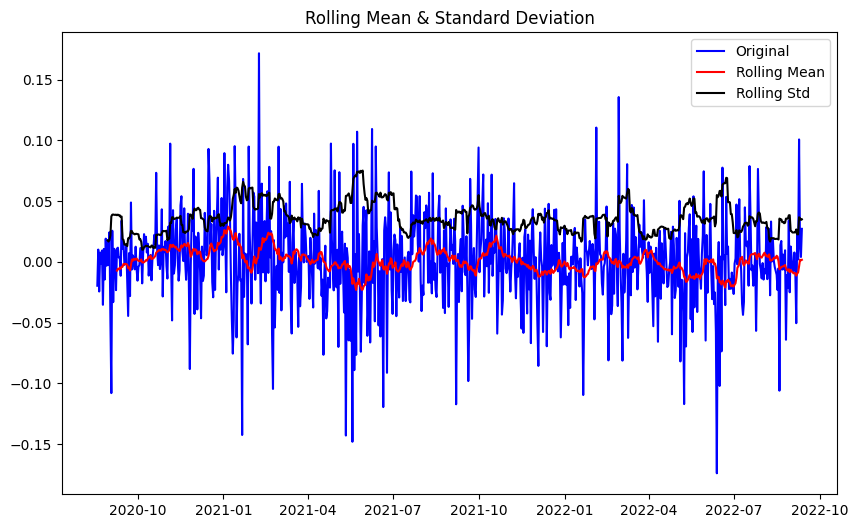

Results of Dickey Fuller Test:
Test Statistic                 -28.047770
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    754.000000
Critical Value (1%)             -3.439053
Critical Value (5%)             -2.865381
Critical Value (10%)            -2.568815
dtype: float64
The graph is stationery


In [672]:
test_stat_log_diff = test_stat_log - test_stat_log.shift()
plt.plot(test_stat_log_diff)
plt.show()

test_stat_log_diff.dropna(inplace=True)
test_stationarity(test_stat_log_diff)

### Test Log Moving Average differences Stationarity

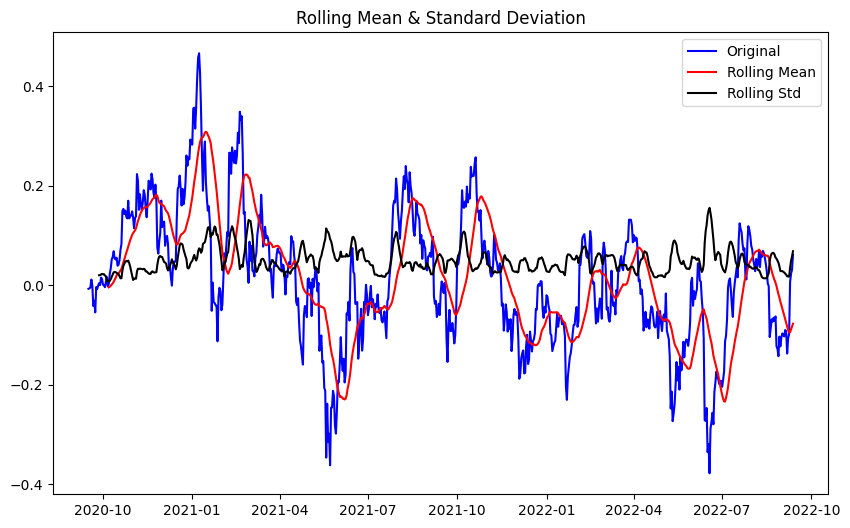

Results of Dickey Fuller Test:
Test Statistic                  -3.884674
p-value                          0.002151
#Lags Used                       0.000000
Number of Observations Used    726.000000
Critical Value (1%)             -3.439389
Critical Value (5%)             -2.865529
Critical Value (10%)            -2.568894
dtype: float64
The graph is stationery


In [673]:
movingAverage = test_stat_log.rolling(window=30).mean()
movingSTD = test_stat_log.rolling(window=30).std()


test_stat_log_minus_MA = test_stat_log - movingAverage
test_stat_log_minus_MA.head(12)

#Remove NAN values
test_stat_log_minus_MA.dropna(inplace=True)
test_stat_log_minus_MA.head(10)


test_stationarity(test_stat_log_minus_MA)

### Analyse Seasonality and Cyclicity of log Difference of bitcoin price 

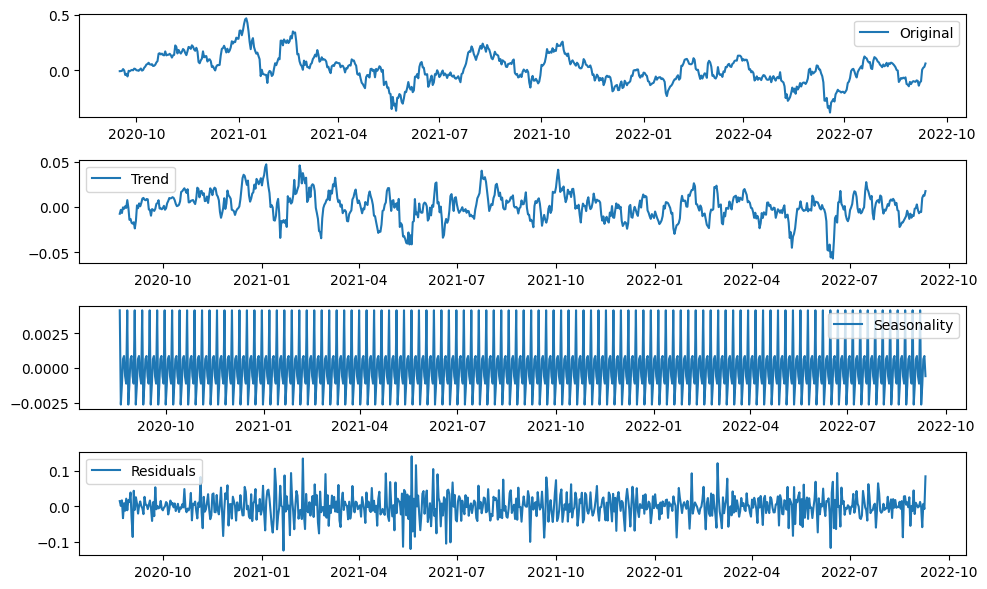

In [674]:
#decompose time series close bitprice data

decomposition = seasonal_decompose(test_stat_log_diff) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(test_stat_log_minus_MA, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()


### Test stationarity of residuals

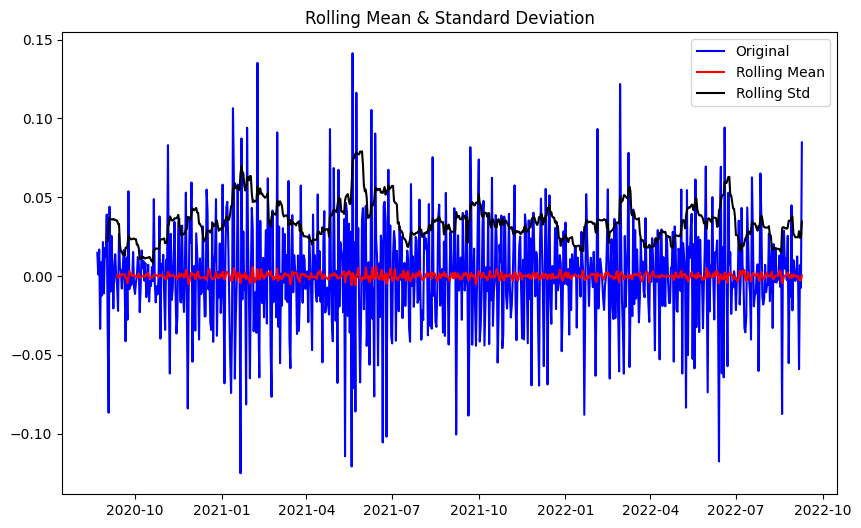

Results of Dickey Fuller Test:
Test Statistic                -1.344833e+01
p-value                        3.726632e-25
#Lags Used                     1.800000e+01
Number of Observations Used    7.300000e+02
Critical Value (1%)           -3.439340e+00
Critical Value (5%)           -2.865507e+00
Critical Value (10%)          -2.568883e+00
dtype: float64
The graph is stationery


In [676]:
#Check if residuals are stationery
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

## Estimation of P and Q from PACF and ACF

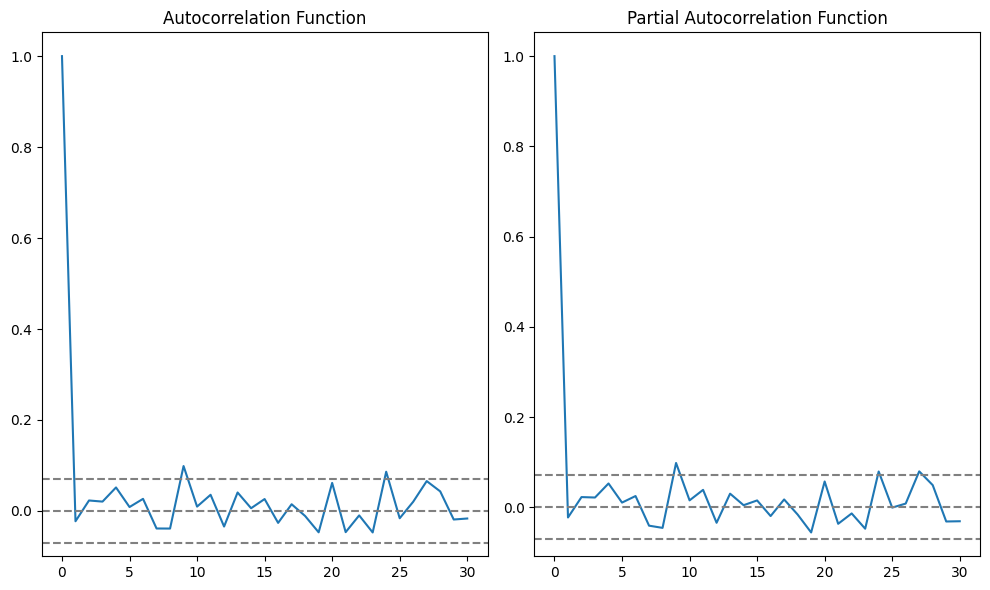

In [677]:
lag_acf = acf(test_stat_log_diff, nlags=30)
lag_pacf = pacf(test_stat_log_diff, nlags=30, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(test_stat_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(test_stat_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(test_stat_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(test_stat_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()       

#from ACF and PACF, P=2 and Q=2

## Building Models
### AR Model

Plotting AR model


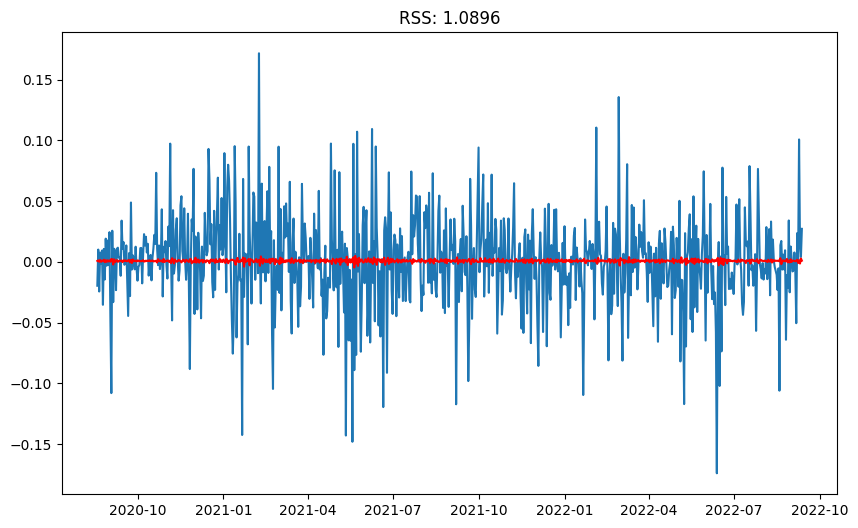

In [678]:
### BUILDING MODELS

## AR model

model = ARIMA(test_stat_log_diff, order=(2,0,0))
results_AR = model.fit()
plt.plot(test_stat_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - test_stat_log_diff)**2))
print('Plotting AR model')


### MA Model

Plotting MA model


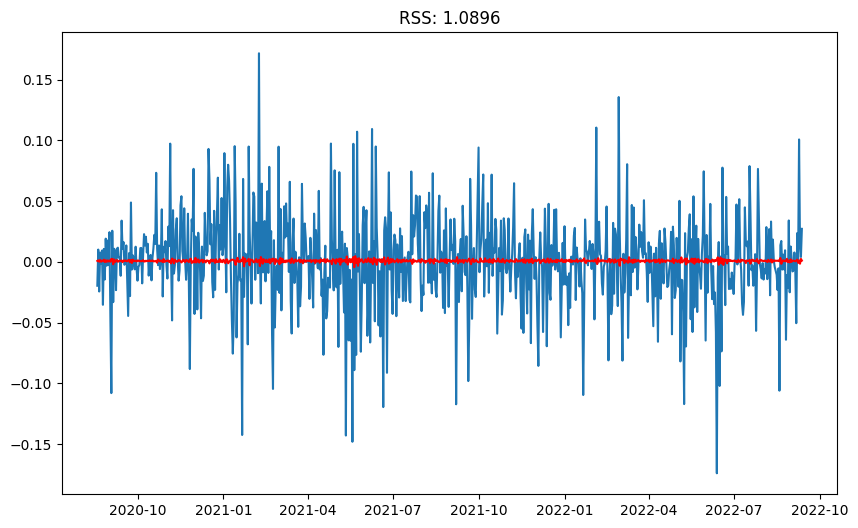

In [679]:
#MA Model

model = ARIMA(test_stat_log_diff, order=(0,0,2))
results_MA = model.fit()
plt.plot(test_stat_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - test_stat_log_diff)**2))
print('Plotting MA model')

### ARIMA MODEL

Plotting ARIMA model


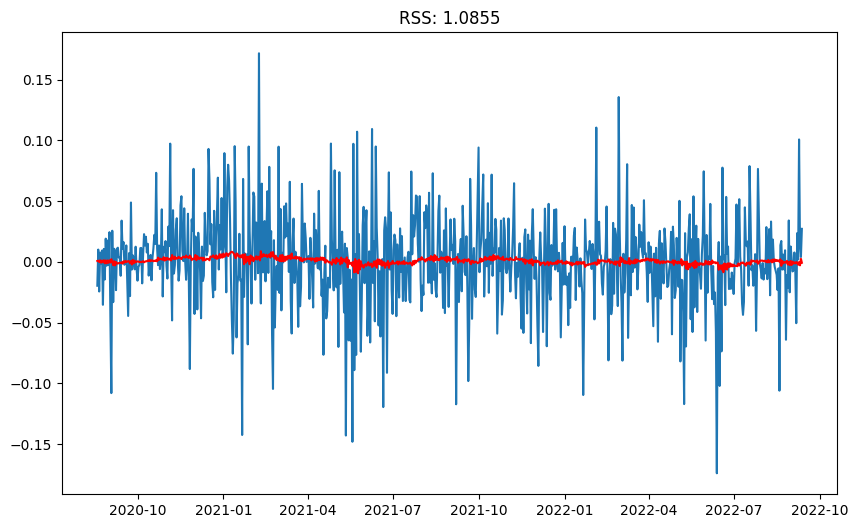

In [680]:
# AR+I+MA = ARIMA model
model = ARIMA(test_stat_log_diff, order=(2,0,2))
results_ARIMA = model.fit()
plt.plot(test_stat_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - test_stat_log_diff)**2))
print('Plotting ARIMA model')

## Train And Validate - Last 100 days validation set
### With no exogeneous variables

Calculating MSE and MAPE...



 Mean MAPE in Predicting Test Case : 2.500200  %

 Mean RMSE in Predicting Test Case : 836.624912247058


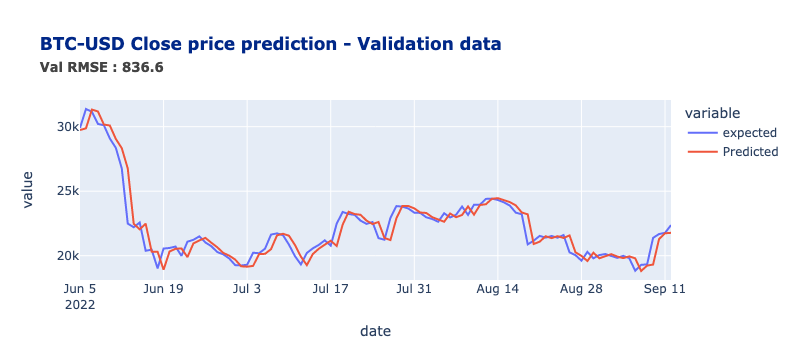

In [682]:
# with no exogeneous regressors

#size = int(len(bitcoin_df2)-100)
bitcoin_train_test = final_df2['close_btc_log']
size = int(len(final_df2)-100)

# Divide into train and test
train_arima, test_arima = bitcoin_train_test[0:size], bitcoin_train_test[size:len(final_df2)]
history = [x for x in train_arima]


predictions = list()
originals = list()
error_list_mape = list()
error_list_mse = list()
print('Calculating MSE and MAPE...')
print('\n')

# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):
    model = ARIMA(history, order=(2, 1, 2))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    pred_value = output[0]

    original_value = test_arima[t]
    history.append(original_value)
    
    #back transform log
    pred_value = np.exp(pred_value)
    original_value = np.exp(original_value)

    # Calculating the error
    error_mape = ((abs(pred_value - original_value)) / original_value) * 100
    error_list_mape.append(error_mape)
    error_mse = (pred_value - original_value)**2
    error_list_mse.append(error_mse)
    

    #print('predicted = %f,   expected = %f,   mape = %f ' % (pred_value, original_value, error_mape), '%')
    #print('predicted = %f,   expected = %f,   mse = %f ' % (pred_value, original_value, error_mse))   
    predictions.append(float(pred_value))
    originals.append(float(original_value))

# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean MAPE in Predicting Test Case : %f ' % (sum(error_list_mape)/float(len(error_list_mape))), '%')
print('\n Mean RMSE in Predicting Test Case :' , (np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))))

val_results = pd.DataFrame(originals,columns=['expected'])
val_results['Predicted'] = predictions
val_results.set_index(bitcoin_train_test[size:len(final_df2)].index,inplace=True)
val_results = (val_results)
rmse = np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))
px.line(val_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Validation data \
        <br><span style="font-size: 13px;color:#444444;">Val RMSE : {:.1f}</span>'.format(rmse))




### VIX index as exogenous variable

Calculating MSE and MAPE...



 Mean MAPE in Predicting Test Case : 2.503276  %

 Mean RMSE in Predicting Test Case : 833.0600977727956


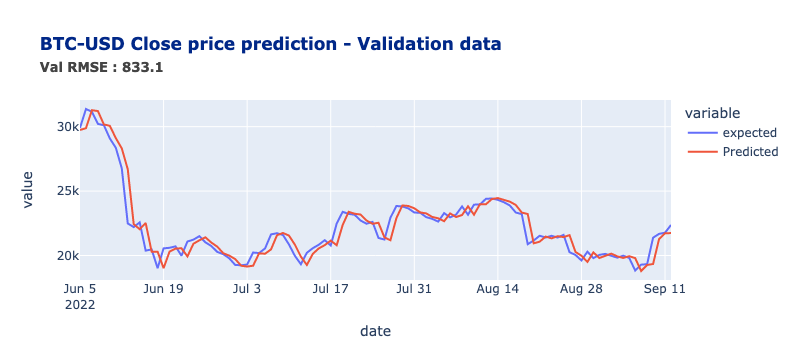

In [683]:
#with volatility index as exogeneous variable

size = int(len(final_df2)-100)
bitcoin_train_test = final_df2[['close_btc_log','open_vix_log']]

# Divide into train and test
train_arima, test_arima = bitcoin_train_test[0:size], bitcoin_train_test[size:len(final_df2)]
history = [x for x in train_arima['close_btc_log']]

exog_variables_train = [x for x in train_arima['open_vix_log']]
exog_variables_test = test_arima['open_vix_log']
predictions = list()
originals = list()
error_list_mape = list()
error_list_mse = list()

print('Calculating MSE and MAPE...')
print('\n')

# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):
    model = ARIMA(history, exog_variables_train, order=(2, 1, 2))
    model_fit = model.fit()
    
    output = model_fit.predict(start=len(history), end=len(final_df2)-1, exog=exog_variables_test)
    pred_value = output[0]
    
    original_value = test_arima['close_btc_log'][t]
    history.append(original_value)
    original_value_exog = test_arima['open_vix_log'][t]

    exog_variables_train.append(original_value_exog)
    exog_variables_test = test_arima['open_vix_log']
    exog_variables_test = exog_variables_test.iloc[t+1:]
    
    #back transform log
    pred_value = np.exp(pred_value)
    original_value = np.exp(original_value)

    # Calculating the error
    error_mape = ((abs(pred_value - original_value)) / original_value) * 100
    error_list_mape.append(error_mape)
    error_mse = (pred_value - original_value)**2
    error_list_mse.append(error_mse)


    #print('predicted = %f,   expected = %f,   mape = %f ' % (pred_value, original_value, error_mape), '%')
    #print('predicted = %f,   expected = %f,   mse = %f ' % (pred_value, original_value, error_mse))
    predictions.append(float(pred_value))
    originals.append(float(original_value))
    
# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean MAPE in Predicting Test Case : %f ' % (sum(error_list_mape)/float(len(error_list_mape))), '%')
print('\n Mean RMSE in Predicting Test Case :' , (np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))))

val_results = pd.DataFrame(originals,columns=['expected'])
val_results['Predicted'] = predictions
val_results.set_index(bitcoin_train_test[size:len(final_df2)].index,inplace=True)
val_results = (val_results)
rmse = np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))
px.line(val_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Validation data \
        <br><span style="font-size: 13px;color:#444444;">Val RMSE : {:.1f}</span>'.format(rmse))





### Gold price as exogeneous variable 

Calculating MSE and MAPE...



 Mean MAPE in Predicting Test Case : 2.506988  %

 Mean RMSE in Predicting Test Case : 839.9299569582265


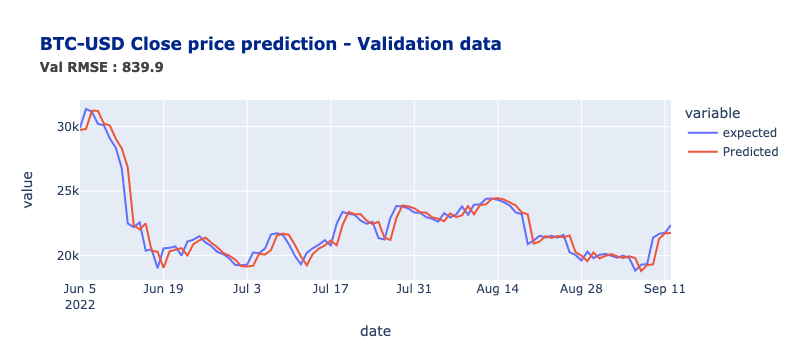

In [684]:
#with gold price as exogeneous variable

size = int(len(final_df2)-100)
bitcoin_train_test = final_df2[['close_btc_log','open_gold_log']]

# Divide into train and test
train_arima, test_arima = bitcoin_train_test[0:size], bitcoin_train_test[size:len(final_df2)]
history = [x for x in train_arima['close_btc_log']]

exog_variables_train = [x for x in train_arima['open_gold_log']]
exog_variables_test = test_arima['open_gold_log']
predictions = list()
originals = list()
error_list_mape = list()
error_list_mse = list()

print('Calculating MSE and MAPE...')
print('\n')

# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):
    model = ARIMA(history, exog_variables_train, order=(2, 1, 2))
    model_fit = model.fit()

    output = model_fit.predict(start=len(history), end=len(final_df2)-1, exog=exog_variables_test)
    pred_value = output[0]
    
    original_value = test_arima['close_btc_log'][t]
    history.append(original_value)
    original_value_exog = test_arima['open_gold_log'][t]

    exog_variables_train.append(original_value_exog)
    exog_variables_test = test_arima['open_gold_log']
    exog_variables_test = exog_variables_test.iloc[t+1:]
    
    #back transform log
    pred_value = np.exp(pred_value)
    original_value = np.exp(original_value)

    # Calculating the error
    error_mape = ((abs(pred_value - original_value)) / original_value) * 100
    error_list_mape.append(error_mape)
    error_mse = (pred_value - original_value)**2
    error_list_mse.append(error_mse)


    #print('predicted = %f,   expected = %f,   mape = %f ' % (pred_value, original_value, error_mape), '%')
    #print('predicted = %f,   expected = %f,   mse = %f ' % (pred_value, original_value, error_mse))
    predictions.append(float(pred_value))
    originals.append(float(original_value))

# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean MAPE in Predicting Test Case : %f ' % (sum(error_list_mape)/float(len(error_list_mape))), '%')
print('\n Mean RMSE in Predicting Test Case :' , (np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))))

val_results = pd.DataFrame(originals,columns=['expected'])
val_results['Predicted'] = predictions
val_results.set_index(bitcoin_train_test[size:len(final_df2)].index,inplace=True)
val_results = (val_results)
rmse = np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))
px.line(val_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Validation data \
        <br><span style="font-size: 13px;color:#444444;">Val RMSE : {:.1f}</span>'.format(rmse))



### Oil price as exogeneous variable

Calculating MSE and MAPE...



 Mean MAPE in Predicting Test Case : 2.527703  %

 Mean RMSE in Predicting Test Case : 835.1715464827704


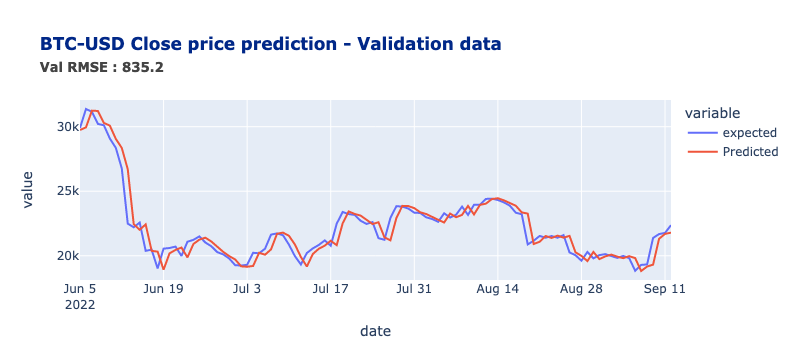

In [685]:
#with oil price as exogeneous variable

size = int(len(final_df2)-100)
bitcoin_train_test = final_df2[['close_btc_log','open_oil_log']]

# Divide into train and test
train_arima, test_arima = bitcoin_train_test[0:size], bitcoin_train_test[size:len(final_df2)]
history = [x for x in train_arima['close_btc_log']]

exog_variables_train = [x for x in train_arima['open_oil_log']]
exog_variables_test = test_arima['open_oil_log']
predictions = list()
originals = list()
error_list_mape = list()
error_list_mse = list()

print('Calculating MSE and MAPE...')
print('\n')

# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):
    model = ARIMA(history, exog_variables_train, order=(2, 1, 2))
    model_fit = model.fit()

    output = model_fit.predict(start=len(history), end=len(final_df2)-1, exog=exog_variables_test)
    pred_value = output[0]
    
    original_value = test_arima['close_btc_log'][t]
    history.append(original_value)
    original_value_exog = test_arima['open_oil_log'][t]

    exog_variables_train.append(original_value_exog)
    exog_variables_test = test_arima['open_oil_log']
    exog_variables_test = exog_variables_test.iloc[t+1:]
    
    #back transform log
    pred_value = np.exp(pred_value)
    original_value = np.exp(original_value)

    # Calculating the error
    error_mape = ((abs(pred_value - original_value)) / original_value) * 100
    error_list_mape.append(error_mape)
    error_mse = (pred_value - original_value)**2
    error_list_mse.append(error_mse)


    #print('predicted = %f,   expected = %f,   mape = %f ' % (pred_value, original_value, error_mape), '%')
    #print('predicted = %f,   expected = %f,   mse = %f ' % (pred_value, original_value, error_mse))
    predictions.append(float(pred_value))
    originals.append(float(original_value))

# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean MAPE in Predicting Test Case : %f ' % (sum(error_list_mape)/float(len(error_list_mape))), '%')
print('\n Mean RMSE in Predicting Test Case :' , (np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))))

val_results = pd.DataFrame(originals,columns=['expected'])
val_results['Predicted'] = predictions
val_results.set_index(bitcoin_train_test[size:len(final_df2)].index,inplace=True)
val_results = (val_results)
rmse = np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))
px.line(val_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Validation data \
        <br><span style="font-size: 13px;color:#444444;">Val RMSE : {:.1f}</span>'.format(rmse))


### EUR/USD as exogeneous variable

Calculating MSE and MAPE...



 Mean MAPE in Predicting Test Case : 2.557626  %

 Mean RMSE in Predicting Test Case : 831.9153401730133


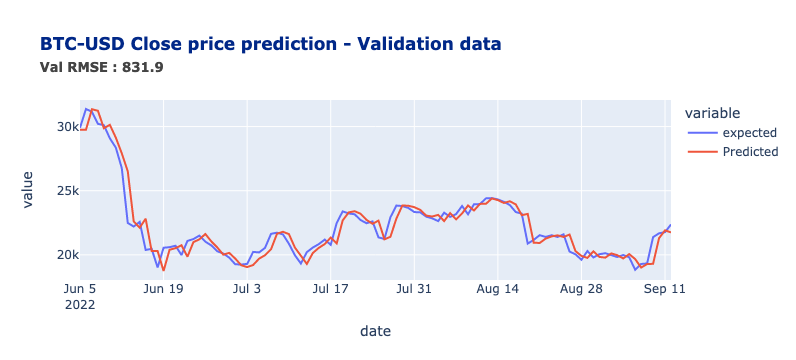

In [686]:
#with eur/usd price as exogeneous variable

size = int(len(final_df2)-100)
bitcoin_train_test = final_df2[['close_btc_log','open_eur_usd_log']]

# Divide into train and test
train_arima, test_arima = bitcoin_train_test[0:size], bitcoin_train_test[size:len(final_df2)]
history = [x for x in train_arima['close_btc_log']]

exog_variables_train = [x for x in train_arima['open_eur_usd_log']]
exog_variables_test = test_arima['open_eur_usd_log']
predictions = list()
originals = list()
error_list_mape = list()
error_list_mse = list()

print('Calculating MSE and MAPE...')
print('\n')

# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):
    model = ARIMA(history, exog_variables_train, order=(2, 1, 2))
    model_fit = model.fit()

    output = model_fit.predict(start=len(history), end=len(final_df2)-1, exog=exog_variables_test)
    pred_value = output[0]
    
    original_value = test_arima['close_btc_log'][t]
    history.append(original_value)
    original_value_exog = test_arima['open_eur_usd_log'][t]

    exog_variables_train.append(original_value_exog)
    exog_variables_test = test_arima['open_eur_usd_log']
    exog_variables_test = exog_variables_test.iloc[t+1:]
    
    #back transform log
    pred_value = np.exp(pred_value)
    original_value = np.exp(original_value)

    # Calculating the error
    error_mape = ((abs(pred_value - original_value)) / original_value) * 100
    error_list_mape.append(error_mape)
    error_mse = (pred_value - original_value)**2
    error_list_mse.append(error_mse)


    #print('predicted = %f,   expected = %f,   mape = %f ' % (pred_value, original_value, error_mape), '%')
    #print('predicted = %f,   expected = %f,   mse = %f ' % (pred_value, original_value, error_mse))
    predictions.append(float(pred_value))
    originals.append(float(original_value))

# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean MAPE in Predicting Test Case : %f ' % (sum(error_list_mape)/float(len(error_list_mape))), '%')
print('\n Mean RMSE in Predicting Test Case :' , (np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))))

val_results = pd.DataFrame(originals,columns=['expected'])
val_results['Predicted'] = predictions
val_results.set_index(bitcoin_train_test[size:len(final_df2)].index,inplace=True)
val_results = (val_results)
rmse = np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))
px.line(val_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Validation data \
        <br><span style="font-size: 13px;color:#444444;">Val RMSE : {:.1f}</span>'.format(rmse))


### CNY/USD as exogeneous variable

Calculating MSE and MAPE...



 Mean MAPE in Predicting Test Case : 2.435541  %

 Mean RMSE in Predicting Test Case : 816.259543747548


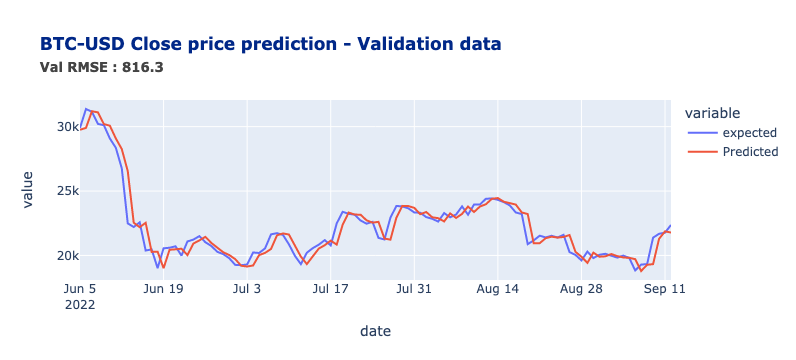

In [687]:
#with cny/usd price as exogeneous variable

size = int(len(final_df2)-100)
bitcoin_train_test = final_df2[['close_btc_log','open_cny_usd_log']]

# Divide into train and test
train_arima, test_arima = bitcoin_train_test[0:size], bitcoin_train_test[size:len(final_df2)]
history = [x for x in train_arima['close_btc_log']]

exog_variables_train = [x for x in train_arima['open_cny_usd_log']]
exog_variables_test = test_arima['open_cny_usd_log']
predictions = list()
originals = list()
error_list_mape = list()
error_list_mse = list()

print('Calculating MSE and MAPE...')
print('\n')

# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):
    model = ARIMA(history, exog_variables_train, order=(2, 1, 2))
    model_fit = model.fit()

    output = model_fit.predict(start=len(history), end=len(final_df2)-1, exog=exog_variables_test)
    pred_value = output[0]
    
    original_value = test_arima['close_btc_log'][t]
    history.append(original_value)
    original_value_exog = test_arima['open_cny_usd_log'][t]

    exog_variables_train.append(original_value_exog)
    exog_variables_test = test_arima['open_cny_usd_log']
    exog_variables_test = exog_variables_test.iloc[t+1:]
    
    #back transform log
    pred_value = np.exp(pred_value)
    original_value = np.exp(original_value)

    # Calculating the error
    error_mape = ((abs(pred_value - original_value)) / original_value) * 100
    error_list_mape.append(error_mape)
    error_mse = (pred_value - original_value)**2
    error_list_mse.append(error_mse)


    #print('predicted = %f,   expected = %f,   mape = %f ' % (pred_value, original_value, error_mape), '%')
    #print('predicted = %f,   expected = %f,   mse = %f ' % (pred_value, original_value, error_mse))
    predictions.append(float(pred_value))
    originals.append(float(original_value))

# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean MAPE in Predicting Test Case : %f ' % (sum(error_list_mape)/float(len(error_list_mape))), '%')
print('\n Mean RMSE in Predicting Test Case :' , (np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))))

val_results = pd.DataFrame(originals,columns=['expected'])
val_results['Predicted'] = predictions
val_results.set_index(bitcoin_train_test[size:len(final_df2)].index,inplace=True)
val_results = (val_results)
rmse = np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))
px.line(val_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Validation data \
        <br><span style="font-size: 13px;color:#444444;">Val RMSE : {:.1f}</span>'.format(rmse))


### JPY/USD as exogeneous variable

Calculating MSE and MAPE...



 Mean MAPE in Predicting Test Case : 2.519856  %

 Mean RMSE in Predicting Test Case : 837.4142097037511


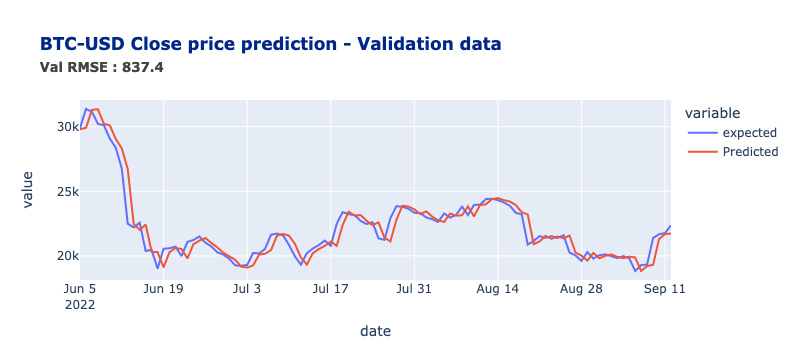

In [688]:
#with jpy/usd price as exogeneous variable

size = int(len(final_df2)-100)
bitcoin_train_test = final_df2[['close_btc_log','open_jpy_usd_log']]

# Divide into train and test
train_arima, test_arima = bitcoin_train_test[0:size], bitcoin_train_test[size:len(final_df2)]
history = [x for x in train_arima['close_btc_log']]

exog_variables_train = [x for x in train_arima['open_jpy_usd_log']]
exog_variables_test = test_arima['open_jpy_usd_log']
predictions = list()
originals = list()
error_list_mape = list()
error_list_mse = list()

print('Calculating MSE and MAPE...')
print('\n')

# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):
    model = ARIMA(history, exog_variables_train, order=(2, 1, 2))
    model_fit = model.fit()

    output = model_fit.predict(start=len(history), end=len(final_df2)-1, exog=exog_variables_test)
    pred_value = output[0]
    
    original_value = test_arima['close_btc_log'][t]
    history.append(original_value)
    original_value_exog = test_arima['open_jpy_usd_log'][t]

    exog_variables_train.append(original_value_exog)
    exog_variables_test = test_arima['open_jpy_usd_log']
    exog_variables_test = exog_variables_test.iloc[t+1:]
    
    #back transform log
    pred_value = np.exp(pred_value)
    original_value = np.exp(original_value)

    # Calculating the error
    error_mape = ((abs(pred_value - original_value)) / original_value) * 100
    error_list_mape.append(error_mape)
    error_mse = (pred_value - original_value)**2
    error_list_mse.append(error_mse)


    #print('predicted = %f,   expected = %f,   mape = %f ' % (pred_value, original_value, error_mape), '%')
    #print('predicted = %f,   expected = %f,   mse = %f ' % (pred_value, original_value, error_mse))
    predictions.append(float(pred_value))
    originals.append(float(original_value))

# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean MAPE in Predicting Test Case : %f ' % (sum(error_list_mape)/float(len(error_list_mape))), '%')
print('\n Mean RMSE in Predicting Test Case :' , (np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))))

val_results = pd.DataFrame(originals,columns=['expected'])
val_results['Predicted'] = predictions
val_results.set_index(bitcoin_train_test[size:len(final_df2)].index,inplace=True)
val_results = (val_results)
rmse = np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))
px.line(val_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Validation data \
        <br><span style="font-size: 13px;color:#444444;">Val RMSE : {:.1f}</span>'.format(rmse))


### SNP500 index as exogeneous variable

Calculating MSE and MAPE...



 Mean MAPE in Predicting Test Case : 2.485615  %

 Mean RMSE in Predicting Test Case : 816.9051697089935


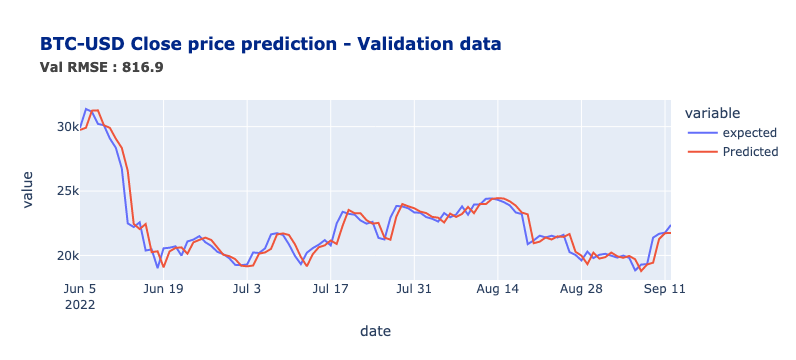

In [689]:
#with snp500 as exogeneous variable

size = int(len(final_df2)-100)
bitcoin_train_test = final_df2[['close_btc_log','open_snp_log']]

# Divide into train and test
train_arima, test_arima = bitcoin_train_test[0:size], bitcoin_train_test[size:len(final_df2)]
history = [x for x in train_arima['close_btc_log']]

exog_variables_train = [x for x in train_arima['open_snp_log']]
exog_variables_test = test_arima['open_snp_log']
predictions = list()
originals = list()
error_list_mape = list()
error_list_mse = list()

print('Calculating MSE and MAPE...')
print('\n')

# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):
    model = ARIMA(history, exog_variables_train, order=(2, 1, 2))
    model_fit = model.fit()

    output = model_fit.predict(start=len(history), end=len(final_df2)-1, exog=exog_variables_test)
    pred_value = output[0]
    
    original_value = test_arima['close_btc_log'][t]
    history.append(original_value)
    original_value_exog = test_arima['open_snp_log'][t]

    exog_variables_train.append(original_value_exog)
    exog_variables_test = test_arima['open_snp_log']
    exog_variables_test = exog_variables_test.iloc[t+1:]
    
    #back transform log
    pred_value = np.exp(pred_value)
    original_value = np.exp(original_value)

    # Calculating the error
    error_mape = ((abs(pred_value - original_value)) / original_value) * 100
    error_list_mape.append(error_mape)
    error_mse = (pred_value - original_value)**2
    error_list_mse.append(error_mse)


    #print('predicted = %f,   expected = %f,   mape = %f ' % (pred_value, original_value, error_mape), '%')
    #print('predicted = %f,   expected = %f,   mse = %f ' % (pred_value, original_value, error_mse))
    predictions.append(float(pred_value))
    originals.append(float(original_value))

# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean MAPE in Predicting Test Case : %f ' % (sum(error_list_mape)/float(len(error_list_mape))), '%')
print('\n Mean RMSE in Predicting Test Case :' , (np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))))

val_results = pd.DataFrame(originals,columns=['expected'])
val_results['Predicted'] = predictions
val_results.set_index(bitcoin_train_test[size:len(final_df2)].index,inplace=True)
val_results = (val_results)
rmse = np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))
px.line(val_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Validation data \
        <br><span style="font-size: 13px;color:#444444;">Val RMSE : {:.1f}</span>'.format(rmse))


### MSCI index as exogeneous variable

Calculating MSE and MAPE...



 Mean MAPE in Predicting Test Case : 2.433232  %

 Mean RMSE in Predicting Test Case : 790.0705076573928


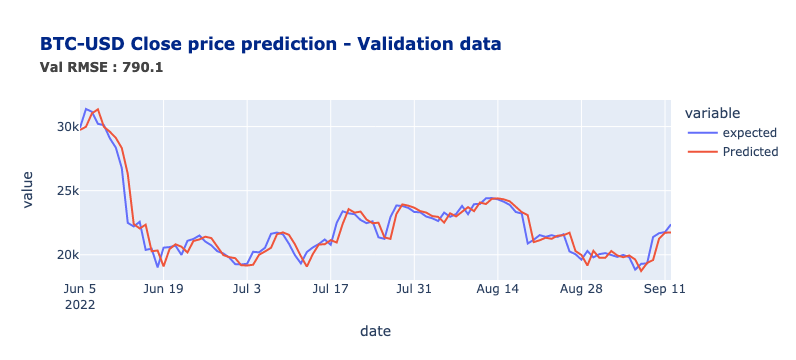

In [690]:
#with msci as exogeneous variable

size = int(len(final_df2)-100)
bitcoin_train_test = final_df2[['close_btc_log','open_msci_log']]

# Divide into train and test
train_arima, test_arima = bitcoin_train_test[0:size], bitcoin_train_test[size:len(final_df2)]
history = [x for x in train_arima['close_btc_log']]

exog_variables_train = [x for x in train_arima['open_msci_log']]
exog_variables_test = test_arima['open_msci_log']
predictions = list()
originals = list()
error_list_mape = list()
error_list_mse = list()

print('Calculating MSE and MAPE...')
print('\n')

# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):
    model = ARIMA(history, exog_variables_train, order=(2, 1, 2))
    model_fit = model.fit()

    output = model_fit.predict(start=len(history), end=len(final_df2)-1, exog=exog_variables_test)
    pred_value = output[0]

    original_value = test_arima['close_btc_log'][t]
    history.append(original_value)
    original_value_exog = test_arima['open_msci_log'][t]

    exog_variables_train.append(original_value_exog)
    exog_variables_test = test_arima['open_msci_log']
    exog_variables_test = exog_variables_test.iloc[t+1:]

    #back transform log
    pred_value = np.exp(pred_value)
    original_value = np.exp(original_value)


    # Calculating the error
    error_mape = ((abs(pred_value - original_value)) / original_value) * 100
    error_list_mape.append(error_mape)
    error_mse = (pred_value - original_value)**2
    error_list_mse.append(error_mse)


    #print('predicted = %f,   expected = %f,   mape = %f ' % (pred_value, original_value, error_mape), '%')
    #print('predicted = %f,   expected = %f,   mse = %f ' % (pred_value, original_value, error_mse))
    predictions.append(float(pred_value))
    originals.append(float(original_value))

# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean MAPE in Predicting Test Case : %f ' % (sum(error_list_mape)/float(len(error_list_mape))), '%')
print('\n Mean RMSE in Predicting Test Case :' , (np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))))

val_results = pd.DataFrame(originals,columns=['expected'])
val_results['Predicted'] = predictions
val_results.set_index(bitcoin_train_test[size:len(final_df2)].index,inplace=True)
val_results = (val_results)
rmse = np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))
px.line(val_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Validation data \
        <br><span style="font-size: 13px;color:#444444;">Val RMSE : {:.1f}</span>'.format(rmse))


### MSCI index and SNP500 index as exogeneous variables

Calculating MSE and MAPE...



 Mean MAPE in Predicting Test Case : 2.405271  %

 Mean RMSE in Predicting Test Case : 785.5781282561903


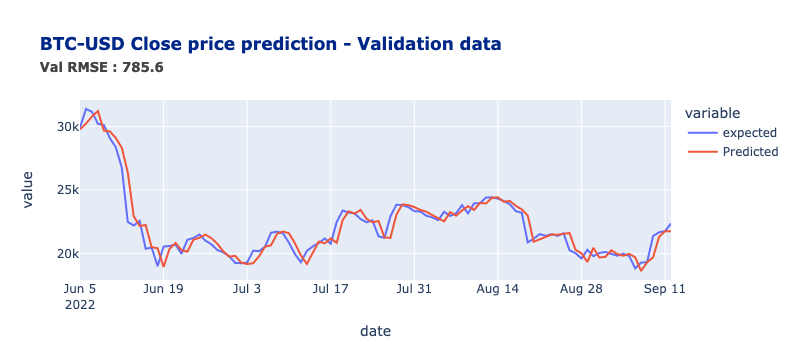

In [691]:
#with msci and snp as exogeneous variable

size = int(len(final_df2)-100)
bitcoin_train_test = final_df2[['close_btc_log','open_msci_log', 'open_snp_log']]


# Divide into train and test
train_arima, test_arima = bitcoin_train_test[0:size], bitcoin_train_test[size:len(final_df2)]
history = [x for x in train_arima['close_btc_log']]

exog_variables_train1 = [x for x in train_arima['open_msci_log']]
exog_variables_train2 = [x for x in train_arima['open_snp_log']]
exog_variables_train = [exog_variables_train1, exog_variables_train2]
exog_variables_train = np.column_stack(exog_variables_train)
exog_variables_test = test_arima[['open_msci_log', 'open_snp_log']]

predictions = list()
originals = list()
error_list_mape = list()
error_list_mse = list()

print('Calculating MSE and MAPE...')
print('\n')

# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):

    model = ARIMA(history, exog_variables_train, order=(2, 1, 2))
    model_fit = model.fit()

    output = model_fit.predict(start=len(history), end=len(final_df2)-1, exog=exog_variables_test)
    pred_value = output[0]

    original_value = test_arima['close_btc_log'][t]
    history.append(original_value)
    original_value_exog1 = test_arima['open_msci_log'][t]
    original_value_exog2 = test_arima['open_snp_log'][t]

    exog_variables_train1.append(original_value_exog1)
    exog_variables_train2.append(original_value_exog2)
    exog_variables_train = [exog_variables_train1,exog_variables_train2]
    exog_variables_train = np.column_stack(exog_variables_train)
    exog_variables_test = test_arima[['open_msci_log', 'open_snp_log']]
    exog_variables_test = exog_variables_test.iloc[t+1:]
    
    #back transform log
    pred_value = np.exp(pred_value)
    original_value = np.exp(original_value)

    # Calculating the error
    error_mape = ((abs(pred_value - original_value)) / original_value) * 100
    error_list_mape.append(error_mape)
    error_mse = (pred_value - original_value)**2
    error_list_mse.append(error_mse)


    #print('predicted = %f,   expected = %f,   mape = %f ' % (pred_value, original_value, error_mape), '%')
    #print('predicted = %f,   expected = %f,   mse = %f ' % (pred_value, original_value, error_mse))
    predictions.append(float(pred_value))
    originals.append(float(original_value))

# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean MAPE in Predicting Test Case : %f ' % (sum(error_list_mape)/float(len(error_list_mape))), '%')
print('\n Mean RMSE in Predicting Test Case :' , (np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))))

val_results = pd.DataFrame(originals,columns=['expected'])
val_results['Predicted'] = predictions
val_results.set_index(bitcoin_train_test[size:len(final_df2)].index,inplace=True)
val_results = (val_results)
rmse = np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))
px.line(val_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Validation data \
        <br><span style="font-size: 13px;color:#444444;">Val RMSE : {:.1f}</span>'.format(rmse))


### MSCI INDEX, SNP500 index and VIX index as exogeneous variables

Printing Predicted vs Expected Values...



 Mean MAPE in Predicting Test : 2.396627  %

 Mean RMSE in Predicting Test : 779.0093448563646


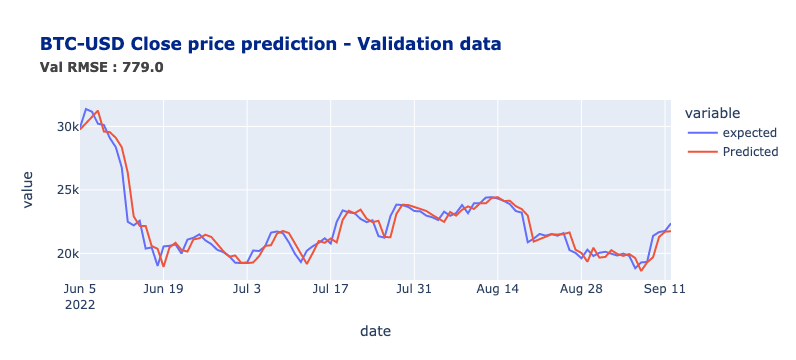

In [692]:
#with msci, snp and vix as exogeneous variable

size = int(len(final_df2)-100)
bitcoin_train_test = final_df2[['close_btc_log','open_msci_log', 'open_snp_log', 'open_vix_log']]


# Divide into train and test
train_arima, test_arima = bitcoin_train_test[0:size], bitcoin_train_test[size:len(final_df2)]
history = [x for x in train_arima['close_btc_log']]

exog_variables_train1 = [x for x in train_arima['open_msci_log']]
exog_variables_train2 = [x for x in train_arima['open_snp_log']]
exog_variables_train3 = [x for x in train_arima['open_vix_log']]
exog_variables_train = [exog_variables_train1, exog_variables_train2, exog_variables_train3]
exog_variables_train = np.column_stack(exog_variables_train)
exog_variables_test = test_arima[['open_msci_log', 'open_snp_log', 'open_vix_log']]

predictions = list()
originals = list()
error_list_mape = list()
error_list_mse = list()

print('Printing Predicted vs Expected Values...')
print('\n')

# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):

    model = ARIMA(history, exog_variables_train, order=(2, 1, 2))
    model_fit = model.fit()

    output = model_fit.predict(start=len(history), end=len(final_df2)-1, exog=exog_variables_test)
    pred_value = output[0]

    original_value = test_arima['close_btc_log'][t]
    history.append(original_value)
    original_value_exog1 = test_arima['open_msci_log'][t]
    original_value_exog2 = test_arima['open_snp_log'][t]
    original_value_exog3 = test_arima['open_vix_log'][t]
    
    exog_variables_train1.append(original_value_exog1)
    exog_variables_train2.append(original_value_exog2)
    exog_variables_train3.append(original_value_exog3)
    exog_variables_train = [exog_variables_train1,exog_variables_train2, exog_variables_train3]
    exog_variables_train = np.column_stack(exog_variables_train)

    exog_variables_test = test_arima[['open_msci_log', 'open_snp_log', 'open_vix_log']]
    exog_variables_test = exog_variables_test.iloc[t+1:]

    #back transform log
    pred_value = np.exp(pred_value)
    original_value = np.exp(original_value)

    # Calculating the error
    error_mape = ((abs(pred_value - original_value)) / original_value) * 100
    error_list_mape.append(error_mape)
    error_mse = (pred_value - original_value)**2
    error_list_mse.append(error_mse)


    #print('predicted = %f,   expected = %f,   mape = %f ' % (pred_value, original_value, error_mape), '%')
    #print('predicted = %f,   expected = %f,   mse = %f ' % (pred_value, original_value, error_mse))
    predictions.append(float(pred_value))
    originals.append(float(original_value))

# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean MAPE in Predicting Test : %f ' % (sum(error_list_mape)/float(len(error_list_mape))), '%')
print('\n Mean RMSE in Predicting Test :' , (np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))))

val_results = pd.DataFrame(originals,columns=['expected'])
val_results['Predicted'] = predictions
val_results.set_index(bitcoin_train_test[size:len(final_df2)].index,inplace=True)
val_results = (val_results)
rmse = np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))
px.line(val_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Validation data \
        <br><span style="font-size: 13px;color:#444444;">Val RMSE : {:.1f}</span>'.format(rmse))


### MSCI index, SNP500 index and twitter sentiments polarity as exogeneous variables

Printing Predicted vs Expected Values...



 MAPE in Predicting Test : 2.405193  %

 RMSE in Predicting Test : 784.611408747579


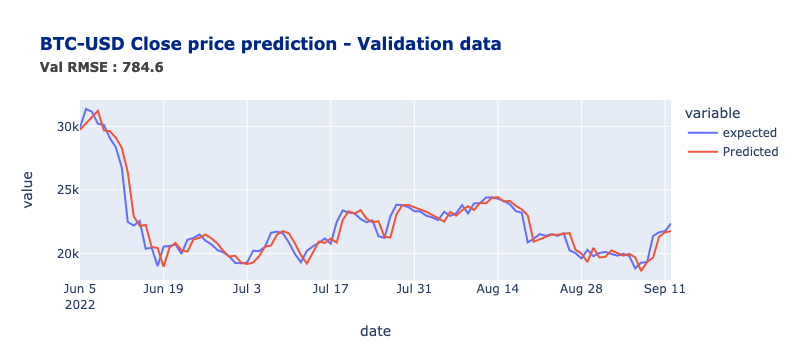

In [693]:
#with msci, snp and sentiments as exogeneous variable
prediction_size = 100
size = int(len(final_df2)-prediction_size)
bitcoin_train_test = final_df2[['close_btc_log', 'open_msci_log', 'open_snp_log', 'Polarity_shift']]


# Divide into train and test
train_arima, test_arima = bitcoin_train_test[0:size], bitcoin_train_test[size:len(final_df2)]
history = [x for x in train_arima['close_btc_log']]

exog_variables_train1 = [x for x in train_arima['open_msci_log']]
exog_variables_train2 = [x for x in train_arima['open_snp_log']]
exog_variables_train3 = [x for x in train_arima['Polarity_shift']]
exog_variables_train = [exog_variables_train1, exog_variables_train2, exog_variables_train3]
exog_variables_train = np.column_stack(exog_variables_train)
exog_variables_test = test_arima[['open_msci_log', 'open_snp_log', 'Polarity_shift']]

predictions = list()
originals = list()
error_list_mape = list()
error_list_mse = list()

print('Printing Predicted vs Expected Values...')
print('\n')

# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):

    model = ARIMA(history, exog_variables_train, order=(2, 1, 2))
    model_fit = model.fit()

    output = model_fit.predict(start=len(history), end=len(final_df2)-1, exog=exog_variables_test)
    pred_value = output[0]

    original_value = test_arima['close_btc_log'][t]
    history.append(original_value)
    original_value_exog1 = test_arima['open_msci_log'][t]
    original_value_exog2 = test_arima['open_snp_log'][t]
    original_value_exog3 = test_arima['Polarity_shift'][t]
    
    exog_variables_train1.append(original_value_exog1)
    exog_variables_train2.append(original_value_exog2)
    exog_variables_train3.append(original_value_exog3)
    exog_variables_train = [exog_variables_train1, exog_variables_train2, exog_variables_train3]
    exog_variables_train = np.column_stack(exog_variables_train)

    exog_variables_test = test_arima[['open_msci_log', 'open_snp_log', 'Polarity_shift']]
    exog_variables_test = exog_variables_test.iloc[t+1:]

    #back transform log
    pred_value = np.exp(pred_value)
    original_value = np.exp(original_value)
   

    # Calculating the error
    error_mape = ((abs(pred_value - original_value)) / original_value) * 100
    error_list_mape.append(error_mape)
    error_mse = (pred_value - original_value)**2
    error_list_mse.append(error_mse)
    

    #print('predicted = %f,   expected = %f,   mape = %f ' % (pred_value, original_value, error_mape), '%')
    #print('predicted = %f,   expected = %f,   mse = %f ' % (pred_value, original_value, error_mse))
    predictions.append(float(pred_value))
    originals.append(float(original_value))

# After iterating over whole test set the overall mean error is calculated.   
print('\n MAPE in Predicting Test : %f ' % (sum(error_list_mape)/float(len(error_list_mape))), '%')
print('\n RMSE in Predicting Test :' , (np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))))

val_results = pd.DataFrame(originals,columns=['expected'])
val_results['Predicted'] = predictions
val_results.set_index(bitcoin_train_test[size:len(final_df2)].index,inplace=True)
val_results = (val_results)
rmse = np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))
px.line(val_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Validation data \
        <br><span style="font-size: 13px;color:#444444;">Val RMSE : {:.1f}</span>'.format(rmse))



### MSCI index, SNP500 index, VIX index and twitter sentiments polarity as exogeneous variables

Printing Predicted vs Expected Values...



 MAPE in Predicting Test : 2.387883  %

 RMSE in Predicting Test : 777.5418020775818


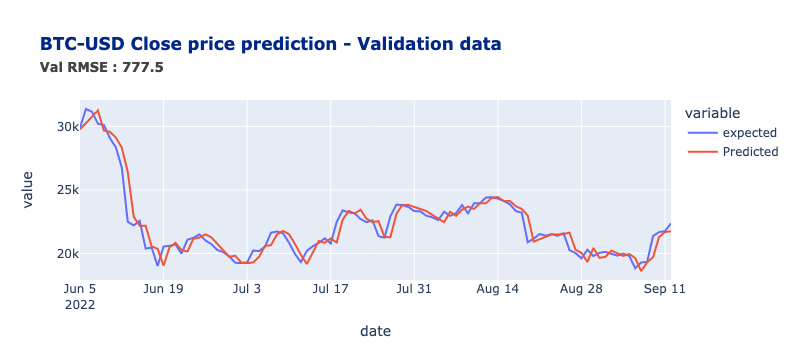

In [694]:
#with msci, snp, vix and sentiments as exogeneous variable
prediction_size = 100
size = int(len(final_df2)-prediction_size)
bitcoin_train_test = final_df2[['close_btc_log', 'open_msci_log', 'open_snp_log', 'open_vix_log', 'Polarity_shift']]


# Divide into train and test
train_arima, test_arima = bitcoin_train_test[0:size], bitcoin_train_test[size:len(final_df2)]
history = [x for x in train_arima['close_btc_log']]

exog_variables_train1 = [x for x in train_arima['open_msci_log']]
exog_variables_train2 = [x for x in train_arima['open_snp_log']]
exog_variables_train3 = [x for x in train_arima['open_vix_log']]
exog_variables_train4 = [x for x in train_arima['Polarity_shift']]
exog_variables_train = [exog_variables_train1, exog_variables_train2, exog_variables_train3, exog_variables_train4]
exog_variables_train = np.column_stack(exog_variables_train)
exog_variables_test = test_arima[['open_msci_log', 'open_snp_log', 'open_vix_log', 'Polarity_shift']]

predictions = list()
originals = list()
error_list_mape = list()
error_list_mse = list()

print('Printing Predicted vs Expected Values...')
print('\n')

# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):

    model = ARIMA(history, exog_variables_train, order=(2, 1, 2))
    model_fit = model.fit()

    output = model_fit.predict(start=len(history), end=len(final_df2)-1, exog=exog_variables_test)
    pred_value = output[0]

    original_value = test_arima['close_btc_log'][t]
    history.append(original_value)
    original_value_exog1 = test_arima['open_msci_log'][t]
    original_value_exog2 = test_arima['open_snp_log'][t]
    original_value_exog3 = test_arima['open_vix_log'][t]
    original_value_exog4 = test_arima['Polarity_shift'][t]
    
    exog_variables_train1.append(original_value_exog1)
    exog_variables_train2.append(original_value_exog2)
    exog_variables_train3.append(original_value_exog3)
    exog_variables_train4.append(original_value_exog4)
    exog_variables_train = [exog_variables_train1, exog_variables_train2, exog_variables_train3, exog_variables_train4]
    exog_variables_train = np.column_stack(exog_variables_train)

    exog_variables_test = test_arima[['open_msci_log', 'open_snp_log', 'open_vix_log', 'Polarity_shift']]
    exog_variables_test = exog_variables_test.iloc[t+1:]

    #back transform log
    pred_value = np.exp(pred_value)
    original_value = np.exp(original_value)


    # Calculating the error
    error_mape = ((abs(pred_value - original_value)) / original_value) * 100
    error_list_mape.append(error_mape)
    error_mse = (pred_value - original_value)**2
    error_list_mse.append(error_mse)

    #print('predicted = %f,   expected = %f,   mape = %f ' % (pred_value, original_value, error_mape), '%')
    #print('predicted = %f,   expected = %f,   mse = %f ' % (pred_value, original_value, error_mse))
    predictions.append(float(pred_value))
    originals.append(float(original_value))

# After iterating over whole test set the overall mean error is calculated.   
print('\n MAPE in Predicting Test : %f ' % (sum(error_list_mape)/float(len(error_list_mape))), '%')
print('\n RMSE in Predicting Test :' , (np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))))

val_results = pd.DataFrame(originals,columns=['expected'])
val_results['Predicted'] = predictions
val_results.set_index(bitcoin_train_test[size:len(final_df2)].index,inplace=True)
val_results = (val_results)
rmse = np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))
px.line(val_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Validation data \
        <br><span style="font-size: 13px;color:#444444;">Val RMSE : {:.1f}</span>'.format(rmse))



### MSCI Index, SNP500 index, VIX index, CNY/USD and twitter sentiments polairy as exogeneous variables

Printing Predicted vs Expected Values...



 MAPE in Predicting Test : 2.373389  %

 RMSE in Predicting Test : 771.0408667868991


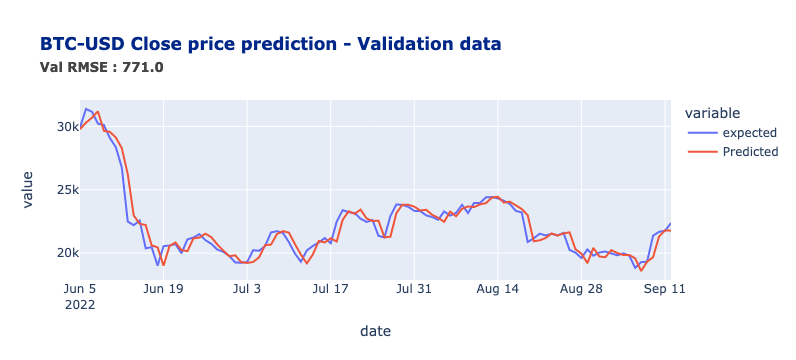

In [699]:
#with msci, snp, vix, cny_usd and sentiments as exogeneous variable
prediction_size = 100
size = int(len(final_df2)-prediction_size)
bitcoin_train_test = final_df2[['close_btc_log', 'open_msci_log', 'open_snp_log', 'open_vix_log', 'open_cny_usd_log', 'Polarity_shift']]


# Divide into train and test
train_arima, test_arima = bitcoin_train_test[0:size], bitcoin_train_test[size:len(final_df2)]
history = [x for x in train_arima['close_btc_log']]

exog_variables_train1 = [x for x in train_arima['open_msci_log']]
exog_variables_train2 = [x for x in train_arima['open_snp_log']]
exog_variables_train3 = [x for x in train_arima['open_vix_log']]
exog_variables_train4 = [x for x in train_arima['open_cny_usd_log']]
exog_variables_train5 = [x for x in train_arima['Polarity_shift']]
exog_variables_train = [exog_variables_train1, exog_variables_train2, exog_variables_train3, exog_variables_train4,
                       exog_variables_train5]
exog_variables_train = np.column_stack(exog_variables_train)
exog_variables_test = test_arima[['open_msci_log', 'open_snp_log', 'open_vix_log', 'open_cny_usd_log', 'Polarity_shift']]

predictions = list()
originals = list()
error_list_mape = list()
error_list_mse = list()

print('Printing Predicted vs Expected Values...')
print('\n')

# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):

    model = ARIMA(history, exog_variables_train, order=(2, 1, 2))
    model_fit = model.fit()

    output = model_fit.predict(start=len(history), end=len(final_df2)-1, exog=exog_variables_test)
    pred_value = output[0]

    original_value = test_arima['close_btc_log'][t]
    history.append(original_value)
    original_value_exog1 = test_arima['open_msci_log'][t]
    original_value_exog2 = test_arima['open_snp_log'][t]
    original_value_exog3 = test_arima['open_vix_log'][t]
    original_value_exog4 = test_arima['open_cny_usd_log'][t]
    original_value_exog5 = test_arima['Polarity_shift'][t]
    
    exog_variables_train1.append(original_value_exog1)
    exog_variables_train2.append(original_value_exog2)
    exog_variables_train3.append(original_value_exog3)
    exog_variables_train4.append(original_value_exog4)
    exog_variables_train5.append(original_value_exog5)
    exog_variables_train = [exog_variables_train1, exog_variables_train2, exog_variables_train3, exog_variables_train4, exog_variables_train5]
    exog_variables_train = np.column_stack(exog_variables_train)

    exog_variables_test = test_arima[['open_msci_log', 'open_snp_log', 'open_vix_log', 'open_cny_usd_log', 'Polarity_shift']]
    exog_variables_test = exog_variables_test.iloc[t+1:]

    #back transform log
    pred_value = np.exp(pred_value)
    original_value = np.exp(original_value)


    # Calculating the error
    error_mape = ((abs(pred_value - original_value)) / original_value) * 100
    error_list_mape.append(error_mape)
    error_mse = (pred_value - original_value)**2
    error_list_mse.append(error_mse)
    

    #print('predicted = %f,   expected = %f,   mape = %f ' % (pred_value, original_value, error_mape), '%')
    #print('predicted = %f,   expected = %f,   mse = %f ' % (pred_value, original_value, error_mse))
    predictions.append(float(pred_value))
    originals.append(float(original_value))

# After iterating over whole test set the overall mean error is calculated.   
print('\n MAPE in Predicting Test : %f ' % (sum(error_list_mape)/float(len(error_list_mape))), '%')
print('\n RMSE in Predicting Test :' , (np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))))

val_results = pd.DataFrame(originals,columns=['expected'])
val_results['Predicted'] = predictions
val_results.set_index(bitcoin_train_test[size:len(final_df2)].index,inplace=True)
val_results = (val_results)
rmse = np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))
px.line(val_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Validation data \
        <br><span style="font-size: 13px;color:#444444;">Val RMSE : {:.1f}</span>'.format(rmse))


## Trading Algorithm Solution 
### 100 days trading period

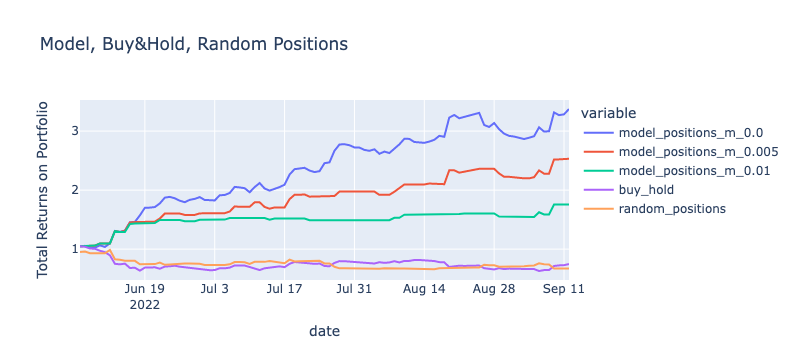

In [696]:
## Trading Strategy on a daily basis - for 100 days trading
##Trading positions and returns



#extract open BTC price
yahoo_financials = YahooFinancials(ticker_BTC)
historical_stock_prices = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
df_btc = pd.DataFrame(historical_stock_prices[ticker_BTC]['prices'])
df_btc = df_btc[['formatted_date','open', 'close']].rename(columns={'formatted_date':'date'})
df_btc = df_btc[size:len(df_btc)]
df_btc['Days'] = np.arange(prediction_size)

#merge model results with extracted BTC open price
df_prediction = pd.DataFrame({'Predicted_close': predictions})
df_prediction['Days'] = np.arange(prediction_size)
df_prediction = pd.merge(df_prediction, df_btc, on='Days').set_index('date')
df_prediction = df_prediction.drop(columns = 'Days')


def trade_positions(pred_df,  margin = 0.00, short=True):
    """
    Gets positions based on the predictions and the actual values. This
    is the logic of the trading strategy.
    """
    if pred_df['open'] < pred_df['Predicted_close']*(1 - margin):
        return 1
    elif pred_df['open'] > pred_df['Predicted_close']*(1 + margin) and short:
        return -1
    else:
        return 0

#model positions
margin_list = [0.00, 0.005, 0.01]
for margin in margin_list:
    positions = df_prediction
    positions[f'model_positions_m_{margin}'] = positions.apply(lambda x: trade_positions(x, margin, short=True), axis=1)

# Buy and hold position
positions['buy_hold'] = 1

# Random positions
random.seed(1)
positions['random_positions'] = random.choices([1,0,-1], k=len(positions))

# Getting log returns during the time period set by the positions before
log_returns = df_prediction[['close']].loc[positions.index].apply(np.log).diff()

bt_positions = positions[['model_positions_m_0.0','model_positions_m_0.005', 'model_positions_m_0.01', 'buy_hold', 'random_positions']]

# The returns during the backtest
returns = bt_positions.multiply(log_returns['close'], axis=0)

# Inversing the log returns to get daily portfolio balance
performance = returns.cumsum().apply(np.exp).dropna().fillna(method='ffill')

# The Final Results
performance.tail(1)


# Visualizing results
fig = px.line(
    performance,
    x=performance.index,
    y=performance.columns,
    title='Model, Buy&Hold, Random Positions',
    labels={"value": "Total Returns on Portfolio",
            "index": "Date"})
fig.show()


### Run Best Model with last 365 days of prediction 

Printing Predicted vs Expected Values...



 MAPE in Predicting Test : 2.526194  %

 RMSE in Predicting Test : 1380.1164120613557


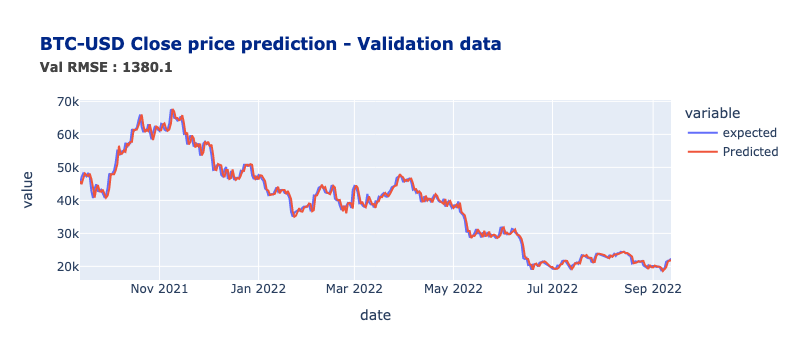

In [697]:
#with msci, snp, vix, cny_usd and sentiments as exogeneous variables - last 365 days as validation set
prediction_size = 365
size = int(len(final_df2)-prediction_size)
bitcoin_train_test = final_df2[['close_btc_log', 'open_msci_log', 'open_snp_log', 'open_vix_log', 'open_cny_usd_log', 'Polarity_shift']]


# Divide into train and test
train_arima, test_arima = bitcoin_train_test[0:size], bitcoin_train_test[size:len(final_df2)]
history = [x for x in train_arima['close_btc_log']]

exog_variables_train1 = [x for x in train_arima['open_msci_log']]
exog_variables_train2 = [x for x in train_arima['open_snp_log']]
exog_variables_train3 = [x for x in train_arima['open_vix_log']]
exog_variables_train4 = [x for x in train_arima['open_cny_usd_log']]
exog_variables_train5 = [x for x in train_arima['Polarity_shift']]
exog_variables_train = [exog_variables_train1, exog_variables_train2, exog_variables_train3, exog_variables_train4,
                       exog_variables_train5]
exog_variables_train = np.column_stack(exog_variables_train)
exog_variables_test = test_arima[['open_msci_log', 'open_snp_log', 'open_vix_log', 'open_cny_usd_log', 'Polarity_shift']]

predictions = list()
originals = list()
error_list_mape = list()
error_list_mse = list()

print('Printing Predicted vs Expected Values...')
print('\n')

# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):

    model = ARIMA(history, exog_variables_train, order=(2, 1, 2))
    model_fit = model.fit()

    output = model_fit.predict(start=len(history), end=len(final_df2)-1, exog=exog_variables_test)
    pred_value = output[0]

    original_value = test_arima['close_btc_log'][t]
    history.append(original_value)
    original_value_exog1 = test_arima['open_msci_log'][t]
    original_value_exog2 = test_arima['open_snp_log'][t]
    original_value_exog3 = test_arima['open_vix_log'][t]
    original_value_exog4 = test_arima['open_cny_usd_log'][t]
    original_value_exog5 = test_arima['Polarity_shift'][t]
    
    exog_variables_train1.append(original_value_exog1)
    exog_variables_train2.append(original_value_exog2)
    exog_variables_train3.append(original_value_exog3)
    exog_variables_train4.append(original_value_exog4)
    exog_variables_train5.append(original_value_exog5)
    exog_variables_train = [exog_variables_train1, exog_variables_train2, exog_variables_train3, exog_variables_train4, exog_variables_train5]
    exog_variables_train = np.column_stack(exog_variables_train)

    exog_variables_test = test_arima[['open_msci_log', 'open_snp_log', 'open_vix_log', 'open_cny_usd_log', 'Polarity_shift']]
    exog_variables_test = exog_variables_test.iloc[t+1:]

    #back transform log
    pred_value = np.exp(pred_value)
    original_value = np.exp(original_value)


    # Calculating the error
    error_mape = ((abs(pred_value - original_value)) / original_value) * 100
    error_list_mape.append(error_mape)
    error_mse = (pred_value - original_value)**2
    error_list_mse.append(error_mse)
    

    #print('predicted = %f,   expected = %f,   mape = %f ' % (pred_value, original_value, error_mape), '%')
    #print('predicted = %f,   expected = %f,   mse = %f ' % (pred_value, original_value, error_mse))
    predictions.append(float(pred_value))
    originals.append(float(original_value))

# After iterating over whole test set the overall mean error is calculated.   
print('\n MAPE in Predicting Test : %f ' % (sum(error_list_mape)/float(len(error_list_mape))), '%')
print('\n RMSE in Predicting Test :' , (np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))))

val_results = pd.DataFrame(originals,columns=['expected'])
val_results['Predicted'] = predictions
val_results.set_index(bitcoin_train_test[size:len(final_df2)].index,inplace=True)
val_results = (val_results)
rmse = np.sqrt(sum(error_list_mse)/float(len(error_list_mse)))
px.line(val_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Validation data \
        <br><span style="font-size: 13px;color:#444444;">Val RMSE : {:.1f}</span>'.format(rmse))


### 365 days trading period

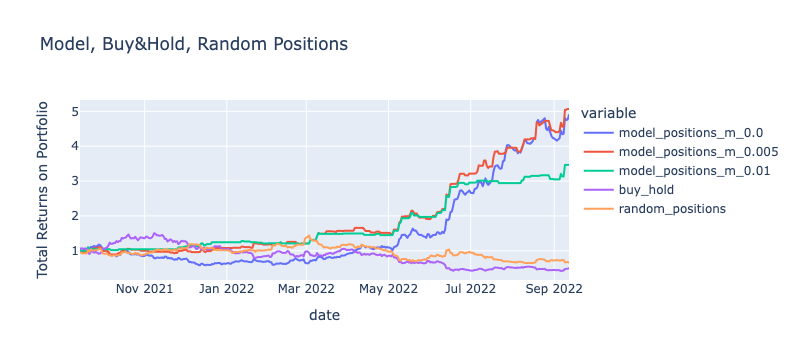

In [698]:
## Trading Strategy on a daily basis - for 365 days trading
##Trading positions and returns

import random
import plotly.express as px

#extract open BTC price
yahoo_financials = YahooFinancials(ticker_BTC)
historical_stock_prices = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
df_btc = pd.DataFrame(historical_stock_prices[ticker_BTC]['prices'])
df_btc = df_btc[['formatted_date','open', 'close']].rename(columns={'formatted_date':'date'})
df_btc = df_btc[size:len(df_btc)]
df_btc['Days'] = np.arange(prediction_size)

#merge model results with extracted BTC open price
df_prediction = pd.DataFrame({'Predicted_close': predictions})
df_prediction['Days'] = np.arange(prediction_size)
df_prediction = pd.merge(df_prediction, df_btc, on='Days').set_index('date')
df_prediction = df_prediction.drop(columns = 'Days')


def trade_positions(pred_df,  margin = 0.00, short=True):
    """
    Gets positions based on the predictions and the actual values. This
    is the logic of the trading strategy.
    """
    if pred_df['open'] < pred_df['Predicted_close']*(1 - margin):
        return 1
    elif pred_df['open'] > pred_df['Predicted_close']*(1 + margin) and short:
        return -1
    else:
        return 0

#model positions
margin_list = [0.00, 0.005, 0.01]
for margin in margin_list:
    positions = df_prediction
    positions[f'model_positions_m_{margin}'] = positions.apply(lambda x: trade_positions(x, margin, short=True), axis=1)

# Buy and hold position
positions['buy_hold'] = 1

# Random positions
random.seed(1)
positions['random_positions'] = random.choices([1,0,-1], k=len(positions))

# Getting log returns during the time period set by the positions before
log_returns = df_prediction[['close']].loc[positions.index].apply(np.log).diff()

bt_positions = positions[['model_positions_m_0.0','model_positions_m_0.005', 'model_positions_m_0.01', 'buy_hold', 'random_positions']]

# The returns during the backtest
returns = bt_positions.multiply(log_returns['close'], axis=0)

# Inversing the log returns to get daily portfolio balance
performance = returns.cumsum().apply(np.exp).dropna().fillna(method='ffill')

# The Final Results
performance.tail(1)


# Visualizing results
fig = px.line(
    performance,
    x=performance.index,
    y=performance.columns,
    title='Model, Buy&Hold, Random Positions',
    labels={"value": "Total Returns on Portfolio",
            "index": "Date"})
fig.show()


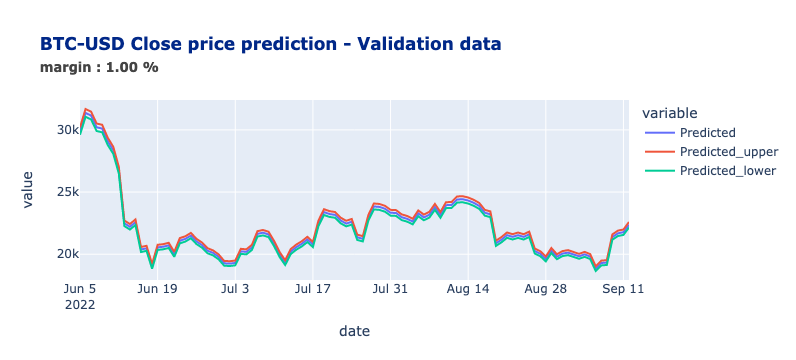

In [708]:
## Plot for margin illustration
m = 0.01
val_results = pd.DataFrame(originals,columns=['Predicted'])
val_results['Predicted_upper'] = val_results['Predicted'] * (1 + m)
val_results['Predicted_lower'] = val_results['Predicted'] * (1 - m)
val_results.set_index(bitcoin_train_test[size:len(final_df2)].index,inplace=True)
val_results = (val_results)
px.line(val_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Validation data \
        <br><span style="font-size: 13px;color:#444444;">margin : {:.2f} %</span>'.format(m*100))

